In [18]:
from drn_interactions.load import load_waveforms, load_derived_generic, load_neurons
from drn_interactions.wavemap import connectivity
from drn_interactions.load import get_derived_data_dir


out_dir = get_derived_data_dir()

from umap import UMAP
import community
import umap.plot
import networkx as nx
from hdbscan import HDBSCAN


from sklearn.preprocessing import (
    MinMaxScaler, 
    RobustScaler, 
    StandardScaler,
    QuantileTransformer,
    PowerTransformer,
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation



import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

out_dir = get_derived_data_dir()

In [2]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [3]:
clusters = load_derived_generic("clusters.csv")
df = load_waveforms().pivot(index="waveform_index", columns="neuron_id", values="waveform_value")

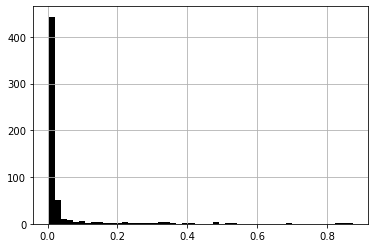

In [4]:
df1 = df.apply(gaussian_filter1d, sigma=3)
scaled = pd.DataFrame(MinMaxScaler().fit_transform(df1), columns=df.columns, index=df.index)
sig_noise = scaled.loc[lambda x: x.index < 100].apply(variation).astype(float)
sig_noise.hist(bins=50, color="black")
bad_neurons = sig_noise[sig_noise > 0.05].index.values
df1 = df1[[c for c in df.columns if c not in bad_neurons]]

In [5]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(MinMaxScaler(), StandardScaler(with_std=False))
pipe2 = MinMaxScaler()

scaled = pd.DataFrame(
    pipe.fit_transform(df1.values), 
    columns=df1.columns, 
    index=df1.index
    )

In [6]:
X = scaled.transpose()

mod = UMAP(n_neighbors=8, min_dist=0, random_state=1).fit(X)
out = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=X.index).reset_index()
out2 = out.merge(clusters)
px.scatter(out2, x="d1", y="d2", color="no_wf_3")

In [10]:
node_mapper = out["neuron_id"].to_dict()

G = nx.from_scipy_sparse_matrix(mod.graph_)
G = nx.relabel_nodes(G, mapping=node_mapper)
partition  = community.best_partition(G, resolution=1, random_state=1)
out["louvain"] = out.neuron_id.map(partition)
    
px.scatter(out, x="d1", y="d2", color="louvain", hover_data=["neuron_id", "louvain"])

In [11]:
to_exclude = out.query("louvain == 9").neuron_id.unique().tolist()

In [51]:
X = scaled[[c for c in scaled if c not in to_exclude]].transpose()

mod = UMAP(n_neighbors=15, min_dist=0, random_state=1).fit(X)
out = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=X.index).reset_index()
out2 = out.merge(clusters)
px.scatter(out2, x="d1", y="d2", color="no_wf_3")

In [52]:
clusterer = HDBSCAN(min_samples=10, cluster_selection_epsilon=0.1) 
clusterer.fit(mod.embedding_)

out["hdb"] = clusterer.labels_
px.scatter(out, x="d1", y="d2", color="hdb")

In [53]:
node_mapper = out["neuron_id"].to_dict()

G = nx.from_scipy_sparse_matrix(mod.graph_)
G = nx.relabel_nodes(G, mapping=node_mapper)
partition  = community.best_partition(G, resolution=1, random_state=1)


out["louvain"] = out.neuron_id.map(partition)
    
px.scatter(out, x="d1", y="d2", color="louvain", hover_data=["neuron_id", "louvain"])

In [62]:
from sklearn.metrics import adjusted_mutual_info_score

scaled = scaled[[c for c in scaled if c not in to_exclude]]

num_neurons = np.arange(10, len(scaled.columns) + 1, 50).astype(int)

df_true = out.copy().rename(columns={"louvain": "true"})[["neuron_id", "true"]]

n_boot = 20


reps = np.empty((n_boot, len(num_neurons)))
for i in range(n_boot):
    for j, neuron in enumerate(num_neurons):
        neurons = np.random.choice(scaled.columns, size=neuron, replace=False).tolist()
        X = scaled[neurons].transpose()
        m = UMAP(n_neighbors=15, min_dist=0, random_state=1).fit(X)
        df_sub =  pd.DataFrame(m.embedding_, columns=["d1", "d2"], index=X.index).reset_index()
        node_mapper = df_sub["neuron_id"].to_dict()
        G = nx.from_scipy_sparse_matrix(m.graph_)
        G = nx.relabel_nodes(G, mapping=node_mapper)
        partition  = community.best_partition(G, resolution=1, random_state=1)
        df_sub["louvain"] = df_sub.neuron_id.map(partition)
        df_sub = df_sub.merge(df_true)
        reps[i, j] = adjusted_mutual_info_score(df_sub["true"].values, df_sub["louvain"].values)
    

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; trun

<AxesSubplot:xlabel='n_neurons', ylabel='value'>

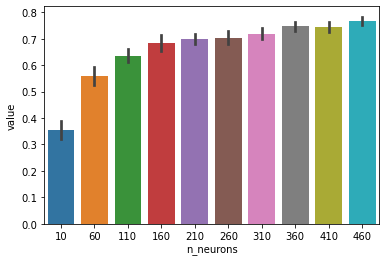

In [63]:
df = pd.DataFrame(reps, columns=num_neurons).reset_index().rename(columns={"index": "boot_idx"})



sns.barplot(data=df.melt(id_vars="boot_idx", var_name="n_neurons"), x="n_neurons", y="value")

In [65]:
from sklearn.metrics import adjusted_mutual_info_score

scaled = scaled[[c for c in scaled if c not in to_exclude]]

num_neurons = np.arange(10, len(scaled.columns) + 1, 50).astype(int)

df_true = out.copy().rename(columns={"hdb": "true"})[["neuron_id", "true"]]

n_boot = 20

reps = np.empty((n_boot, len(num_neurons)))
for i in range(n_boot):
    for j, neuron in enumerate(num_neurons):
        neurons = np.random.choice(scaled.columns, size=neuron, replace=False).tolist()
        X = scaled[neurons].transpose()
        m = UMAP(n_neighbors=15, min_dist=0, random_state=1).fit(X)
        df_sub =  pd.DataFrame(m.embedding_, columns=["d1", "d2"], index=X.index).reset_index()
        clusterer = HDBSCAN(min_samples=10, cluster_selection_epsilon=0.1) 
        clusterer.fit(m.embedding_)
        df_sub["hdb"] = clusterer.labels_
        df_sub = df_sub.merge(df_true)
        reps[i, j] = adjusted_mutual_info_score(df_sub["true"].values, df_sub["hdb"].values)
    

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\umap\umap_.py:2214: UserWarning:

n_neighbors is larger than the dataset size; trun

<AxesSubplot:xlabel='n_neurons', ylabel='value'>

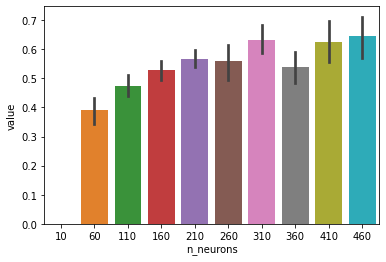

In [66]:
df = pd.DataFrame(reps, columns=num_neurons).reset_index().rename(columns={"index": "boot_idx"})



sns.barplot(data=df.melt(id_vars="boot_idx", var_name="n_neurons"), x="n_neurons", y="value")

<AxesSubplot:>

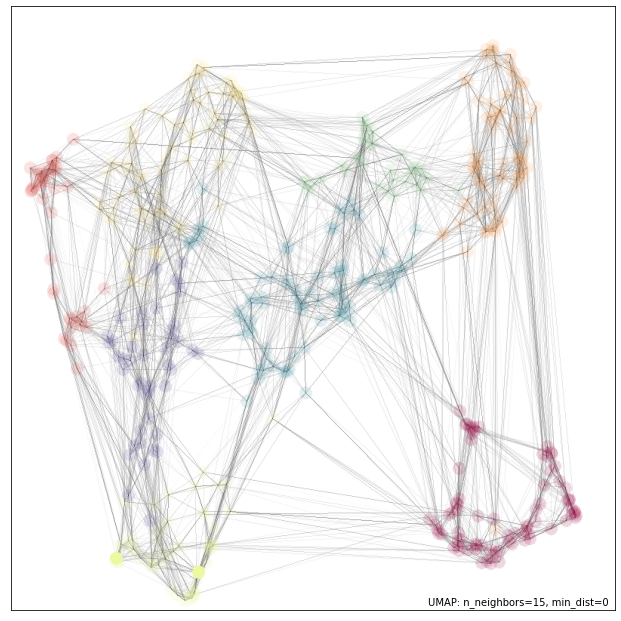

In [16]:
connectivity(mod, values=out["louvain"], show_points=True,
     px_size=50, threshold=0.92, cmap="Spectral")

In [48]:
d1 = out["d1"]
d2 = out["d2"]

corners = np.array(
    [out.d1.min(), out.d1.min(), out.d1.max(), out.d1.max(),
    out.d2.min(), out.d2.min(), out.d2.max(), out.d2.max()],
).reshape(4, 2)



test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [56]:
x = np.linspace(out.d1.min(), out.d1.max(), 5)
y = np.linspace(out.d2.min(), out.d2.max(), 5)
x, y = np.meshgrid(x, y)
positions = np.vstack([x.ravel(), y.ravel()])

In [57]:
pos = positions.T

inv_transformed_points = mod.inverse_transform(pos)

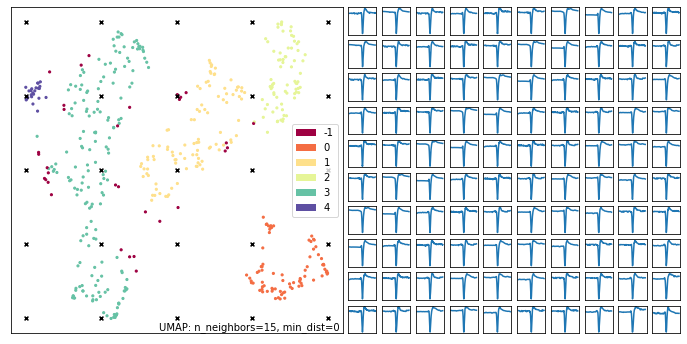

In [67]:
from matplotlib.gridspec import GridSpec

labels = out["hdb"].values

fig = plt.figure(figsize=(12,6))

gs = GridSpec(10, 20, fig)

scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis

umap.plot.points(mod, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mod.embedding_[:, 0], mod.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
# scatter_ax.set(xticks=[], yticks=[])

# # Plot the locations of the text points
scatter_ax.scatter(positions[0, :], positions[1, :], marker='x', c='k', s=15)


for i in range(10):
    for j in range(10):
        digit_axes[i, j].plot(inv_transformed_points[i + j, :])
        digit_axes[i, j].set(xticks=[], yticks=[])